# CS5489 - Machine Learning
# Lecture 2b - Naive Bayes Classifier
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Naive Bayes Gaussian Classifier - Iris dataset
1. Gaussian Classifier - Iris dataset
1. Naive Bayes Spam Classifier - Spam dataset

# Naive Bayes Classifier
- How to deal with multiple features?
  - e.g., $\mathbf{x} = \begin{bmatrix}x_1\\x_2\end{bmatrix}$
- **Naive Bayes assumption**
  - assume each feature dimension is modeled independently.
    - the joint probability is the product of the individual probabilities
    - e.g., for 2 dimensions, $p(x_1,x_2|y) = p(x_1|y)p(x_2|y)$
    - accumulates evidence from each feature dimension:
      - $\log p(x_1,x_2|y) = \log p(x_1|y)+\log p(x_2|y)$ 
  - allows us to model each dimension of the observation with a simple univariate distribution.
- **Example: Naive Bayes Gaussian classifier**
  - We will consider the 2-dimensional iris data shown in the beginning of lecture.

# Setup Python

In [59]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # display larger images
import matplotlib
from mpl_toolkits import mplot3d
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)          # specify a seed so results are reproducible

# Load data

In [60]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label ( versicolor=1, virginica=2)
Y = Y.astype('int')  # convert to integer
print(X.shape)

(100, 2)


# View data

In [61]:
# a colormap for making the scatter plot: class 1 will be red, class 2 will be green
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

axbox = [2.5, 7, 1.5, 4] # common axis range

# a function for setting a common plot
def irisaxis():
    plt.xlabel('petal length'); plt.ylabel('sepal width')
    plt.axis([2.5, 7, 1.5, 4]); plt.grid(True)

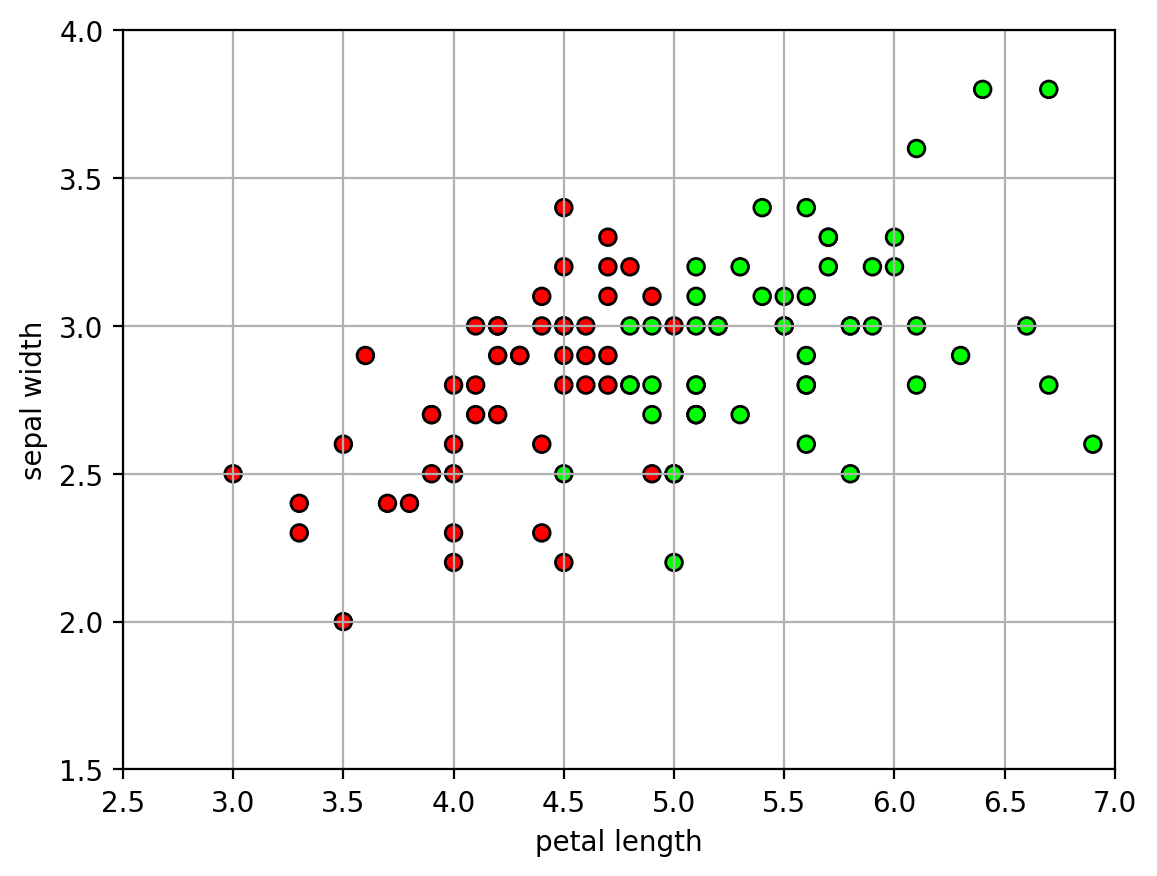

In [62]:
# show the data
plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
# c is the color value, drawn from colormap mycmap
irisaxis()

# Split training/test data
- We will select 50% of the data for training, and 50% for testing
  - use `model_selection` module
    - `train_test_split` - give the percentage for training and testing.
    - `StratifiedShuffleSplit` - also preserves the percentage of examples for each class.

In [63]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
     train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(50, 2)
(50, 2)


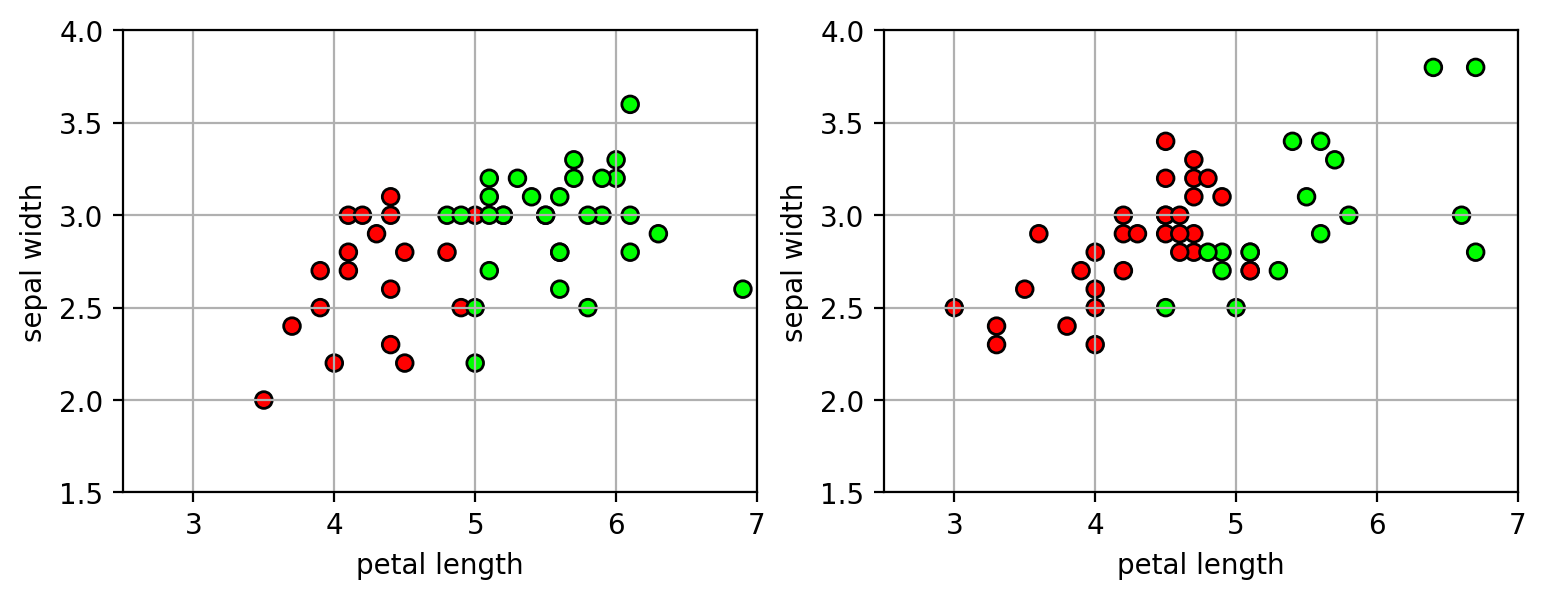

In [64]:
# view train & test data
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)   # put two subplots in the same figure
# scatter plot - Y value selects the color 
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
irisaxis()

plt.subplot(1,2,2)
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, edgecolors='k')
irisaxis()

# Learn Gaussian NB model
- treat each feature dimension as an independent Gaussian
- class conditionals densities:
  - $p(\mathbf{x}|y=c) = {\cal N}(x_1|\mu_{c,1}, \sigma^2_{c,1}){\cal N}(x_2|\mu_{c,2}, \sigma^2_{c,2})$
  - each dimension $j$ has its own mean $\mu_{c,j}$ and variance $\sigma^2_{c,j}$ for class $c$.
- ${\cal N}(x|\mu, \sigma^2)$ is a Gaussian with mean $\mu$ and variance $\sigma^2$.

In [65]:
# get the NB Gaussian model from sklearn
model = naive_bayes.GaussianNB()

# fit the model to training data
model.fit(trainX, trainY)

# see the parameters
print("class prior: ",  model.class_prior_)
print("class 1 mean: ", model.theta_[0,:])
print("class 1 var:  ", model.var_[0,:])
print("class 2 mean: ", model.theta_[1,:])
print("class 2 var:  ", model.var_[1,:])

class prior:  [0.38 0.62]
class 1 mean:  [4.26842105 2.65789474]
class 1 var:   [0.14426593 0.09927978]
class 2 mean:  [5.57741935 2.96451613]
class 2 var:   [0.22045786 0.07777315]


- View 2d class conditionals: 
  - $p(x_1,x_2|y=c)={\cal N}(x_1|\mu_{c,1}, \sigma^2_{c,1}){\cal N}(x_2|\mu_{c,2}, \sigma^2_{c,2})$
- the NB Gaussian defines a "hill" of probability, whose contours are concentric ellipses.
  - ellipses are aligned with the axes.

In [66]:
# plot the class-conditional density
def plot_ccd(pdf, axbox, plot3d=False):
    
    if plot3d:
        N = 50
    else:
        N = 200
    
    xr = [ linspace(axbox[0], axbox[1], N), 
           linspace(axbox[2], axbox[3], N) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
    
    # calculate the posterior probability
    px = pdf(allpts)
    px1 = px.reshape(xgrid0.shape)

    if plot3d:
        #ax = plt.axes(projection='3d')
        ax = plt.gca()
        ax.plot_surface(xgrid0, xgrid1, px1, rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none')        
    else:
        # show contour plot of density    
        plt.imshow(px1, origin='lower', extent=axbox, alpha=0.70, cmap=plt.get_cmap('Blues_r'))
        plt.contour(xr[0], xr[1], px1, linewidths=0.5, colors='k')  #cmap=plt.get_cmap('Blues_r'))


In [67]:
ccd = plt.figure(figsize=(10,6))  # set the figure size
for c in range(2):
    plt.subplot(1,2,c+1)
    pdf0 = stats.norm(loc=model.theta_[c,0],
                    scale=sqrt(model.var_[c,0]))
    pdf1 = stats.norm(loc=model.theta_[c,1],
                      scale=sqrt(model.var_[c,1]))   
    p = lambda x: pdf1.pdf(x[:,1])*pdf0.pdf(x[:,0])
    plot_ccd(p, axbox)

    # show the training data
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.title("class conditional p(x|y="+str(c+1)+")");
    irisaxis()
plt.close()

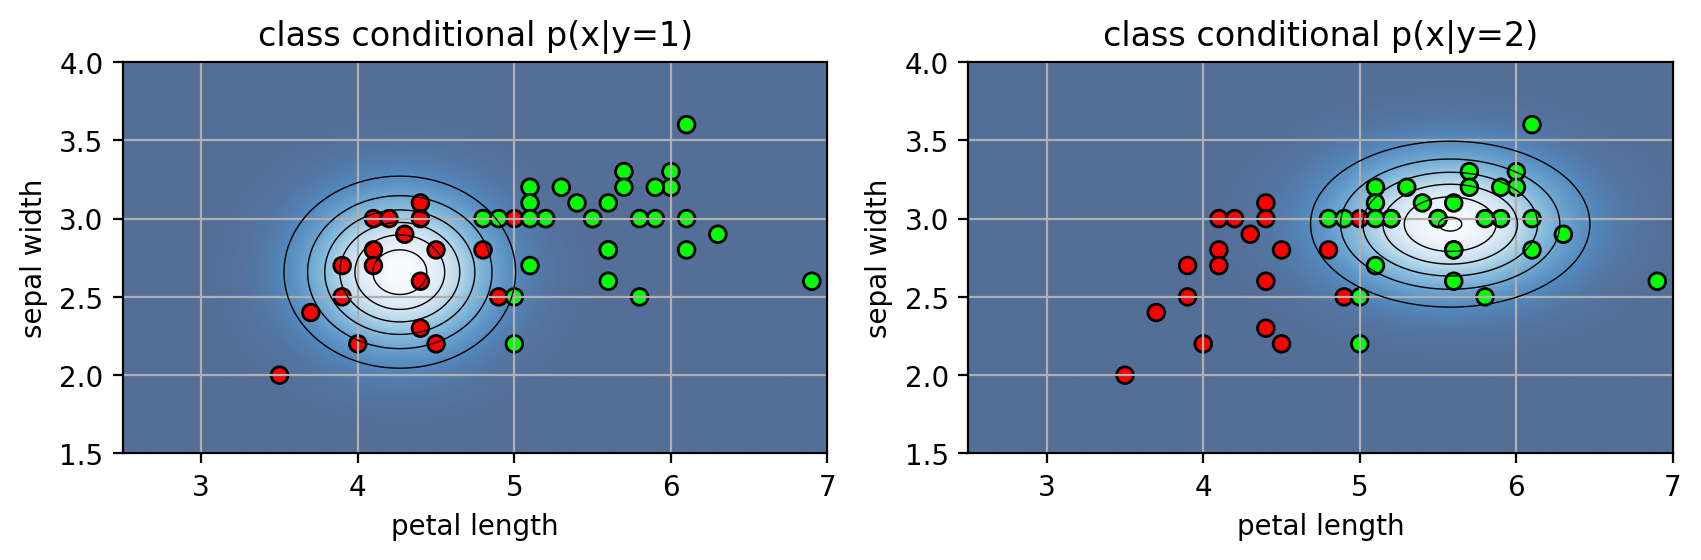

In [68]:
ccd

In [69]:
ccd3d = plt.figure(figsize=(10,4))
for c in range(2):
    plt.subplot(1,2,c+1, projection='3d')
   # ccd3d[c] = plt.figure(figsize=(7,4))  # set the figure size
    pdf0 = stats.norm(loc=model.theta_[c,0],
                    scale=sqrt(model.var_[c,0]))
    pdf1 = stats.norm(loc=model.theta_[c,1],
                      scale=sqrt(model.var_[c,1]))   
    p = lambda x: pdf1.pdf(x[:,1])*pdf0.pdf(x[:,0])
    plot_ccd(p, axbox, plot3d=True)

    # show the training data
    plt.title("class conditional p(x|y="+str(c+1)+")");
plt.close()

- 3d surface plots

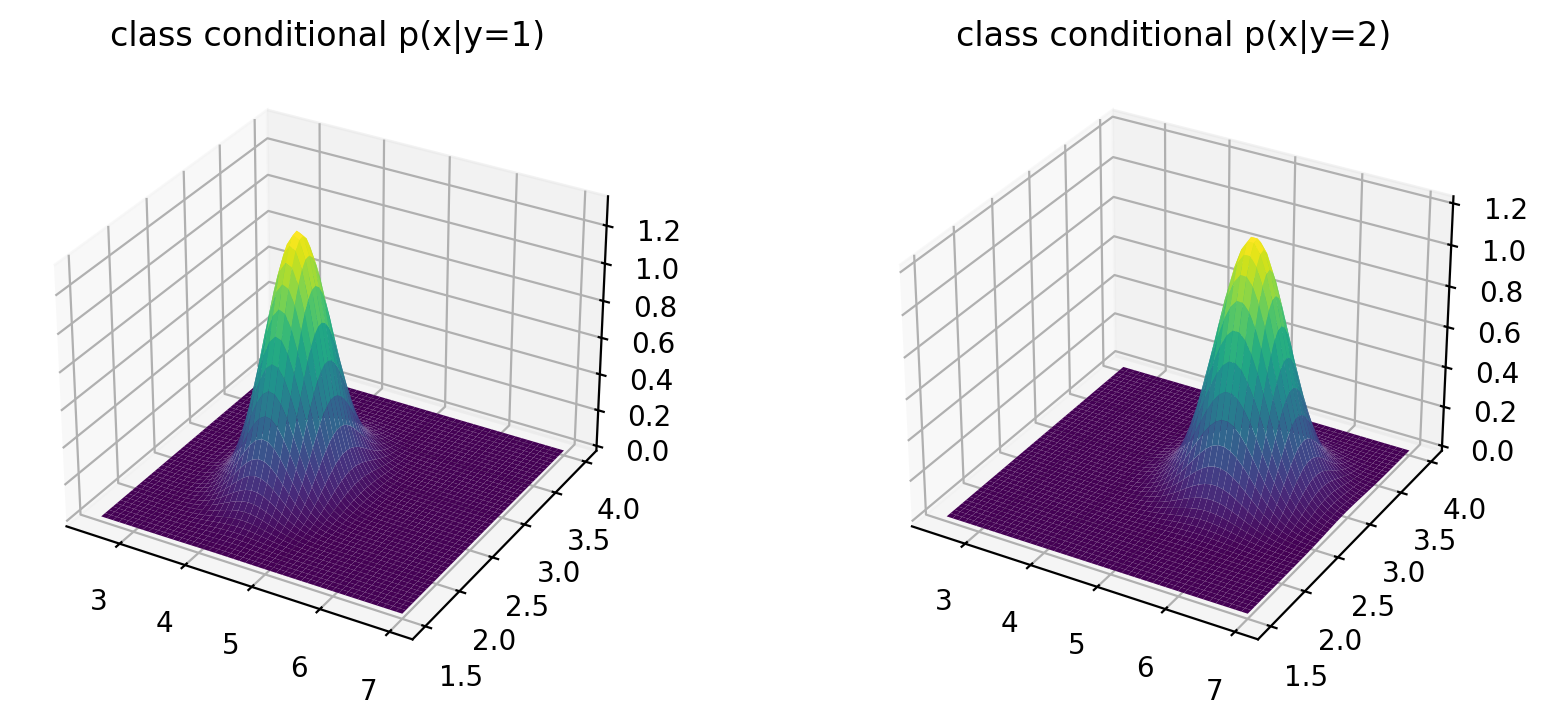

In [70]:
ccd3d

In [71]:
## Visualization  ###############################################################################################
def plot_ellipse(ax, musigma, color="k", lw=1):
    """
    Based on
    http://stackoverflow.com/questions/17952171/not-sure-how-to-fit-data-with-a-gaussian-python.
    """

    mu, sigma = musigma
    
    # Compute eigenvalues and associated eigenvectors
    vals, vecs = linalg.eigh(sigma)

    # Compute "tilt" of ellipse using first eigenvector
    x, y = vecs[:, 0]
    theta = degrees(arctan2(y, x))

    # Eigenvalues give length of ellipse along each eigenvector
    # plot 2 stdevs
    w, h = 2 * sqrt(vals) * 2

    #ax.tick_params(axis='both', which='major', labelsize=20)
    ellipse = matplotlib.patches.Ellipse(mu, w, h, angle=theta, fill=False, color=color, lw=lw)  # color="k")
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_alpha(1.0)
    ax.add_artist(ellipse) 

In [72]:
def plot_posterior(model, axbox, mycmap, showlabels=True):
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the posterior probability
    post = model.predict_proba(allpts)
    # extract the posterior for class 2, and reshape into a grid
    post1 = post[:,1].reshape(xgrid0.shape)

    # contour plot of the posterior and decision boundary
    plt.imshow(post1, origin='lower', extent=axbox, alpha=0.50, cmap=mycmap)
    if showlabels:
        plt.colorbar(shrink=0.6)
    CS = plt.contour(xr[0], xr[1], post1, cmap=mycmap, levels=[0.1, 0.3, 0.7, 0.9], alpha=0.8)
    if showlabels:
        #plt.colorbar(CS)
        plt.clabel(CS, inline=1, fontsize=10)
    plt.contour(xr[0], xr[1], post1, levels=[0.5], linestyles='dashed', colors='black')
    irisaxis()

# View the Posterior
- the posterior probability decreases near the class boundary due to the uncertainty in the prediction.
- the ellipses are the contours of the CCD.

In [73]:
pfig = plt.figure(figsize=(9,8))
plot_posterior(model, axbox, mycmap, showlabels=True)
plot_ellipse(plt.gca(), (model.theta_[0,:], diag(model.var_[0,:])), color='r')
plot_ellipse(plt.gca(), (model.theta_[1,:], diag(model.var_[1,:])), color='g')
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.title('posterior p(y=2|x) with training data');
plt.close()

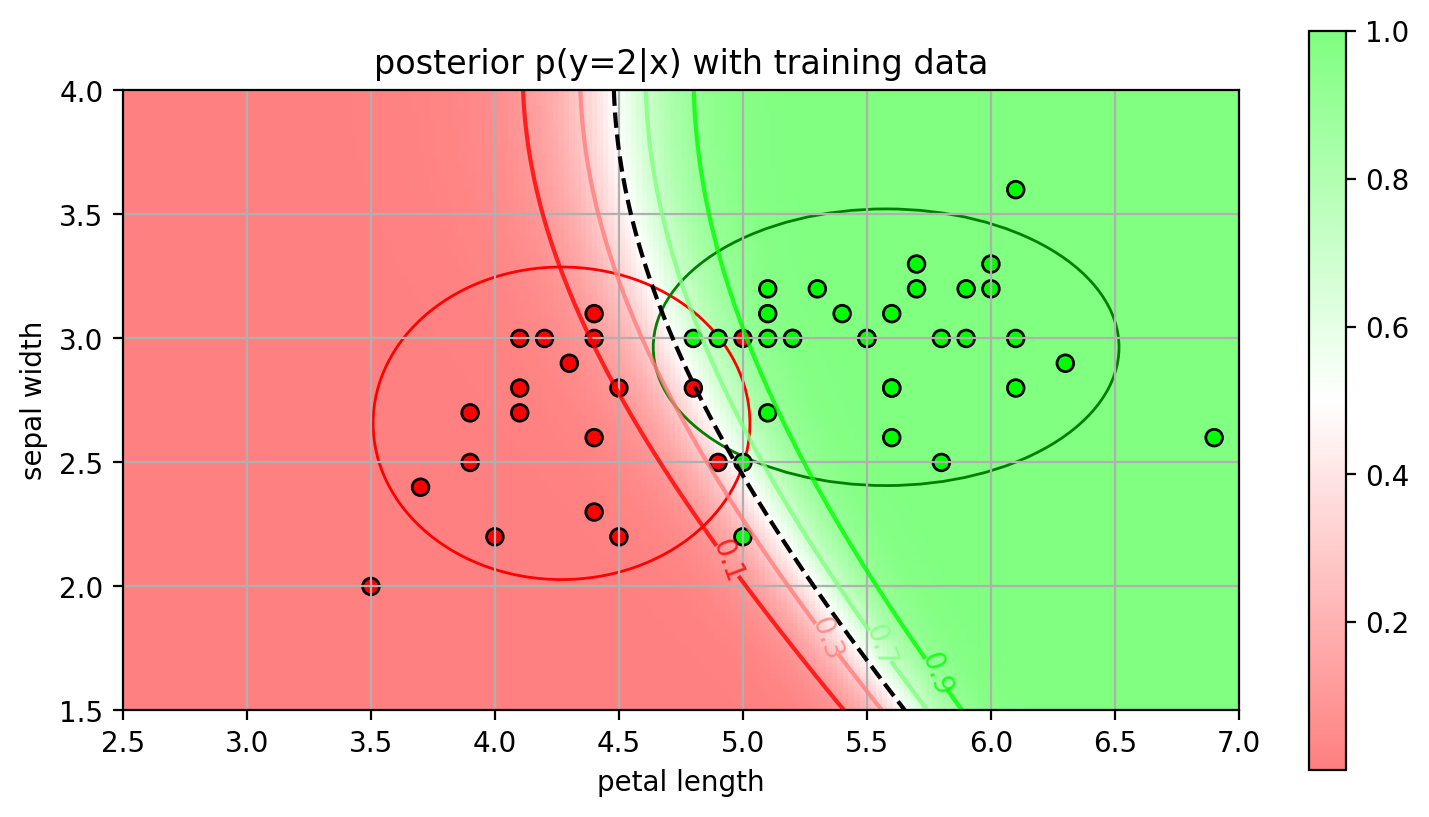

In [74]:
pfig

# Evaluate on the test set

In [75]:
# predict from the model
predY = model.predict(testX)
print("pred: ", predY)
print("true: ", testY)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("accuracy=", acc)

pred:  [2 2 1 2 1 2 1 1 1 2 2 2 2 2 2 1 2 2 1 2 1 1 1 1 1 1 1 1 2 1 2 1 2 2 1 1 1
 1 1 1 2 1 2 2 2 1 2 2 1 1]
true:  [2 2 1 2 1 2 1 1 1 1 1 2 2 2 2 1 2 2 1 1 1 1 2 1 1 1 1 1 2 1 2 1 2 2 1 1 2
 1 1 1 1 1 1 2 2 1 1 2 1 1]
accuracy= 0.84


# Viewing test results

In [76]:
tfig = plt.figure(figsize=(9,8))
# contour plot of the posterior and decision boundary
plot_posterior(model, axbox, mycmap, showlabels=True)
# show the test data
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, edgecolors='k')

# get test errors and mark them on the plot with a square
ni = where(testY!=predY)  # returns indices
plt.plot(testX[ni,0], testX[ni,1], 'ks', markeredgewidth=1, fillstyle='none')
irisaxis()
plt.title('posterior p(y=2|x) with test data');
plt.close()

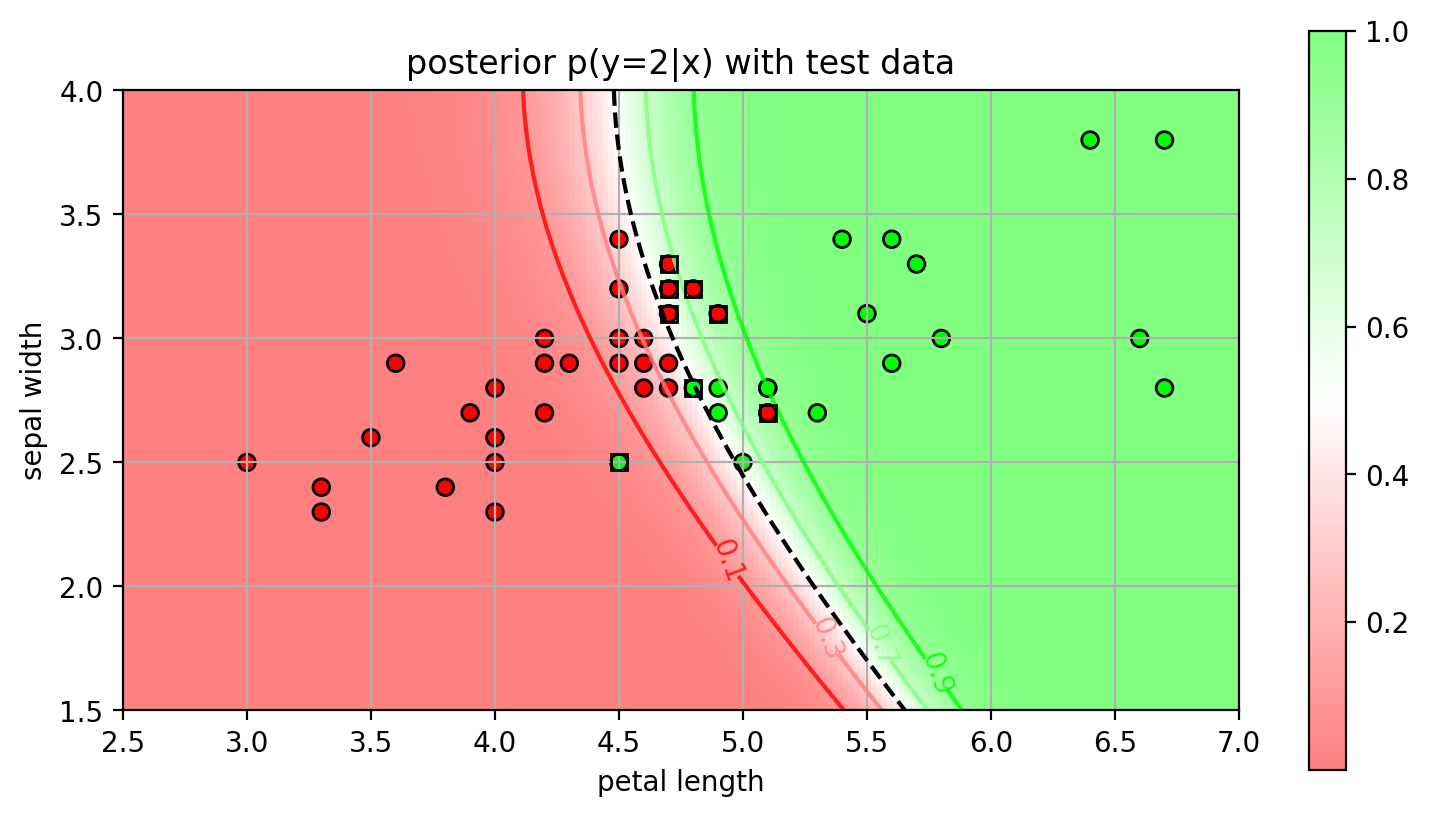

In [77]:
tfig

# Naive Bayes(NB) Assumption
- NB Gaussian assumes the features are independent
  - the features do not vary together
    - e.g., knowing one feature tells us nothing about the other 
  - in the iris data, the features for class 1 seem to vary together.
    - e.g., larger petal length $\rightarrow$ larger sepal width
- How to model covariance between features?
  - need to remove the NB assumption, and model the distribution of feature vectors $\mathbf{x}$.

- Multivariate Gaussian:
  - ${\cal N}(\mathbf{x}|\mathbf{\mu}, \mathbf{\Sigma}) = \frac{1}{(2\pi)^{d/2} |\mathbf{\Sigma}|^{1/2}}e^{-\frac{1}{2} \|\mathbf{x} - \mathbf{\mu}\|^2_{\mathbf{\Sigma}}}$
    - parameters: mean $\mathbf{\mu}$, covariance matrix $\mathbf{\Sigma}$.
    - Mahalanobis distance: $\|\mathbf{x} - \mathbf{\mu}\|^2_{\mathbf{\Sigma}} = (\mathbf{x} - 
\mathbf{\mu})^T\mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu})$ is a weighted distance according to $\mathbf{\Sigma}$.
    - Determinant: $|\mathbf{\Sigma}|$ is the determinant of $\mathbf{\Sigma}$, corresponds to the "volume" defined by the matrix.


- Parameters
  - mean vector $\mathbf{\mu} = \begin{bmatrix}\mu_1\\\vdots\\\mu_d\end{bmatrix}$, $\mu_j$ is the mean for the $j$-th feature.
  - covariance matrix $$\begin{bmatrix} \sigma^2_1 & \sigma_{12} & \cdots & \sigma_{1d} \\ \sigma_{21} & \sigma^2_2 & \cdots & \sigma_{2d} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{d1} & \sigma_{d2} & \cdots  & \sigma^2_d\end{bmatrix}$$
    - $\sigma_j^2$ is the variance of the j-th feature.
    - $\sigma_{ij}$ is the covariance between the i-th and j-th features.
      - if $(i,j)$ feature pair varies in the same direction, then $\sigma_{ij}>0$.
      - if $(i,j)$ feature pair varies in opposite directions, then $\sigma_{ij}<0$. 
      - if $i,j$ features are independent (don't vary together), then $\sigma_{ij}=0$




- 2D examples:

$$\mathbf{\Sigma}_1 = \begin{bmatrix}1&0\\0&1\end{bmatrix}, \mathbf{\Sigma}_2 =\begin{bmatrix}1&0.5\\0.5&1\end{bmatrix}, \mathbf{\Sigma}_3 =\begin{bmatrix}1&0.9\\0.9&1\end{bmatrix}, \mathbf{\Sigma}_4 =\begin{bmatrix}1&-0.9\\-0.9&1\end{bmatrix}$$

In [78]:
from scipy.stats import multivariate_normal as mvn
mu=array([0,0])
Sigma = [array([[1,0],[0,1]]), 
         array([[1,0.5],[0.5,1]]), 
        array([[1,0.9],[0.9,1]]), 
        array([[1,-0.9],[-0.9,1]])]
mvnfig = plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(1,4,i+1)
    plot_ccd(lambda x: mvn.pdf(x, mean=mu, cov=Sigma[i]), [-3,3,-3,3])
    plt.title('${\cal N}(0,\mathbf{\Sigma}_' + str(i+1)+')$')
plt.close()

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/var/folders/w5/3147k6n509qfnprxx70qr6fc0000gn/T/ipykernel_7115/538533524.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.title('${\cal N}(0,\mathbf{\Sigma}_' + str(i+1)+')$')


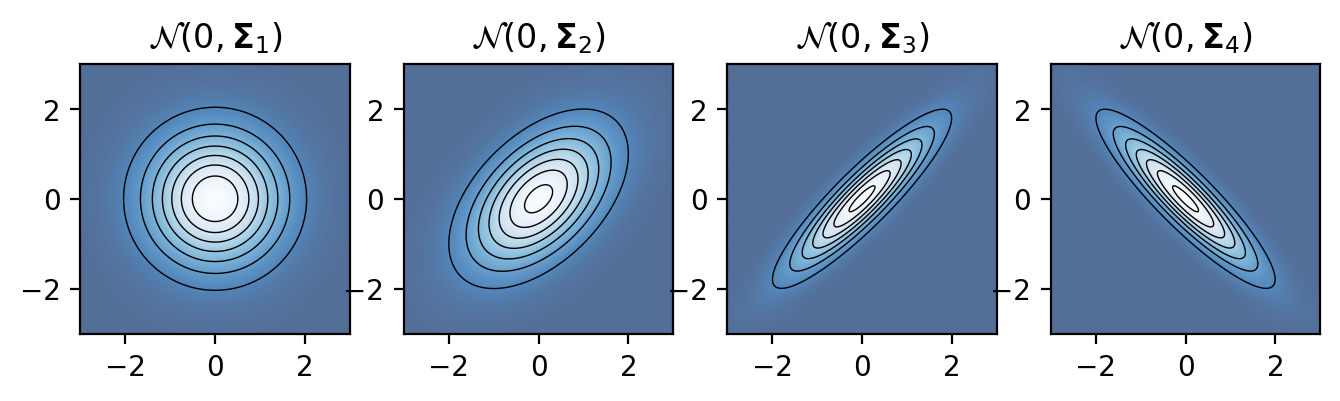

In [79]:
mvnfig

- model the class conditional density as a multivariate Gaussian distribution:
  - $p(\mathbf{x}|y=c) = {\cal N}(\mathbf{x}|\mathbf{\mu}_c, \mathbf{\Sigma}_c)$
- Estimate the parameters with MLE:
  - Given the samples $\{\mathbf{x}_1,\cdots,\mathbf{x}_N\}$.
    - $\mathbf{\mu} = \frac{1}{N}\sum_{i=1}^N \mathbf{x}_i$ &rArr; sample mean
    - $\mathbf{\Sigma} = \frac{1}{N}\sum_{i=1}^N (\mathbf{x}_i - \mathbf{\mu})(\mathbf{x}_i - \mathbf{\mu})^T$ &rArr; sample covariance

  

- regularize the covariance by adding a constant to the diagonal.
  - $\mathbf{\Sigma} \leftarrow \mathbf{\Sigma} + \alpha \mathbf{I}$
  - expands the Gaussian outwards in all directions, prevents collapsing on a single point.

In [80]:
from scipy.stats import multivariate_normal as mvn
mu=array([0,0])
Sigma = [array([[1,0.9],[0.9,1]]), 
        array([[1.1,0.9],[0.9,1.1]])]
mvnfig2 = plt.figure(figsize=(8,8))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot_ccd(lambda x: mvn.pdf(x, mean=mu, cov=Sigma[i]), [-3,3,-3,3])
    if i==0:
        plt.title('${\cal N}(0,\mathbf{\Sigma}_3)$')
    else:
        plt.title('${\cal N}(0,\mathbf{\Sigma}_3+ 0.1\mathbf{I})$')
plt.close()

<>:10: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:10: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/w5/3147k6n509qfnprxx70qr6fc0000gn/T/ipykernel_7115/618808229.py:10: SyntaxWarning: invalid escape sequence '\c'
  plt.title('${\cal N}(0,\mathbf{\Sigma}_3)$')
/var/folders/w5/3147k6n509qfnprxx70qr6fc0000gn/T/ipykernel_7115/618808229.py:12: SyntaxWarning: invalid escape sequence '\c'
  plt.title('${\cal N}(0,\mathbf{\Sigma}_3+ 0.1\mathbf{I})$')


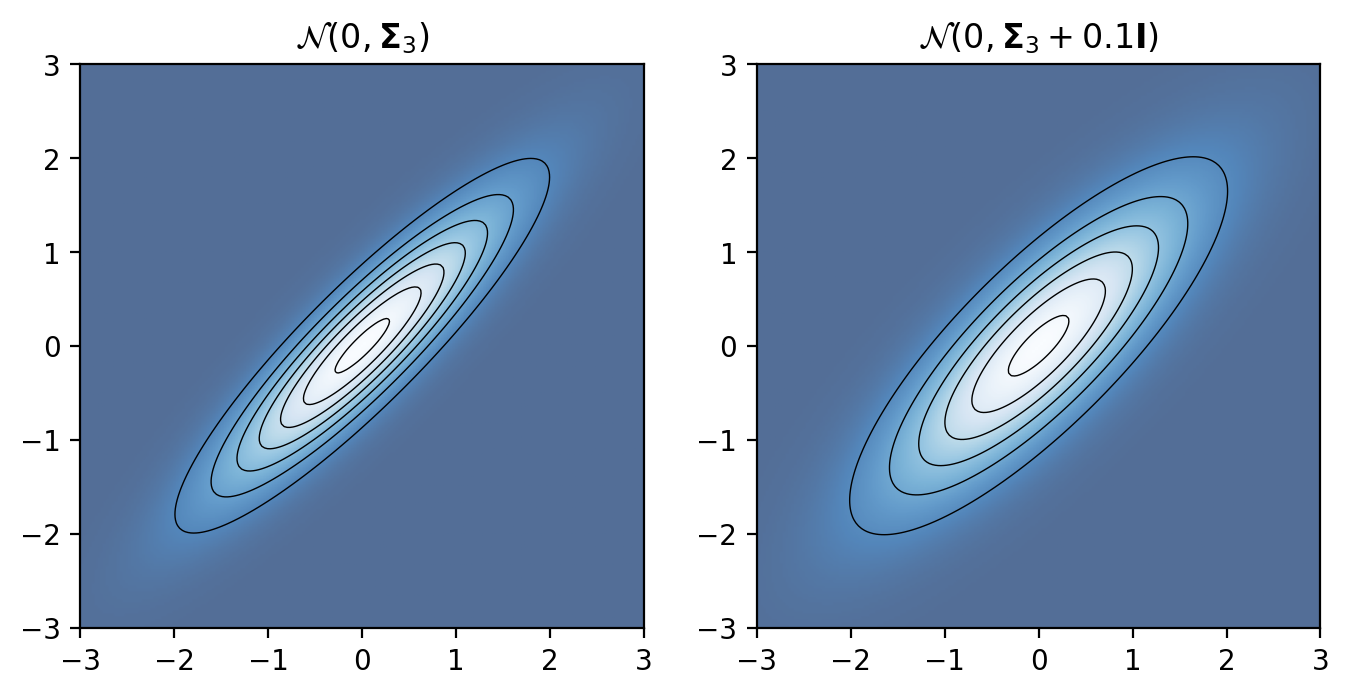

In [81]:
mvnfig2

- Create class for Gaussian Bayes Classifier

In [82]:
# multivariate Gaussian functions
from scipy.stats import multivariate_normal as mvn
from scipy.special import logsumexp

class GaussianBayes:
    # constructor: 
    #  alpha is the regularizer on the covariance matrix: Sigma + alpha*I
    def __init__(self, alpha=0.0):
        self.alpha = alpha
    
    # Fit the model: assumes classes are [0,1,2,...K-1]
    # K is the max value in y
    def fit(self, X, y):
        # get the number of classes
        K = max(y)+1
        self.K = K
        
        # estimate mean and covariance
        self.mu = []
        self.Sigma = []
        for c in range(K):
            Xc = X[y==c]   # select samples for this class
            # estimate the mean and covariance
            self.mu.append( mean(Xc, axis=0) )
            self.Sigma.append( cov(Xc, rowvar=False) + self.alpha*eye(len(Xc[0])) )
            
        # estimate class priors
        tmp = []
        for c in range(K):
            tmp.append( count_nonzero(y==c) ) # number of Class c
        self.pi = array(tmp) / len(y)  # divide by the total
    
    # compute the log CCD for class c, log p(x|y=c)
    def compute_logccd(self, X, c):
        lx = mvn.logpdf(X, mean=self.mu[c], cov=self.Sigma[c])
        return lx
    
    # compute the joint log-likelihood: log p(x,y)
    def compute_logjoint(self, X):
        # compute log joint likelihood: log p(x|y) + log p(y)
        jl = []
        for c in range(self.K):
            jl.append( self.compute_logccd(X, c) + log(self.pi[c]) )
        
        # p[i,c] = log p(X[i]|y=c)
        p = stack( jl, axis=-1 )
        return p
        
    # compute the posterior log-probability of each class given X
    def predict_logproba(self, X):        
        lp = self.compute_logjoint(X)  # compute joint loglikelihoods
        lpx = logsumexp(lp, axis=1)    # compute log p(x) = log sum_c exp( log p(x,y))
        return lp - lpx[:,newaxis]     # compute log posterior: log p(y|x) = log p(x,y) - log p(x)
    
    # compute the posterior probability of each class given X
    def predict_proba(self, X):
        return exp( self.predict_logproba(X) )
    
    # compute the most likely class given X
    def predict(self, X):
        lp = self.compute_logjoint(X)   # compute joint likelihoods
        c = argmax(lp, axis=1)          # find the maximum
        return c                        # return the class label

- fit the Gaussian classifier

In [83]:
gb = GaussianBayes()
gb.fit(trainX, trainY-1)  # map from 1...2 to 0...1
print(gb.mu)
print(gb.Sigma)

[array([4.26842105, 2.65789474]), array([5.57741935, 2.96451613])]
[array([[0.1522807 , 0.05081871],
       [0.05081871, 0.10479532]]), array([[0.22780645, 0.01650538],
       [0.01650538, 0.08036559]])]


In [84]:
ccd2 = plt.figure(figsize=(10,6))  # set the figure size
for c in range(2):
    plt.subplot(1,2,c+1)
    
    plot_ccd(lambda x: exp(gb.compute_logccd(x,c)), axbox)

    # show the training data
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.title("class conditional p(x|y="+str(c+1)+")");
    irisaxis()
plt.close()

- CCDs for each class
  - the contours of the Gaussian are tilted with the data
    - thus, the features are covarying.

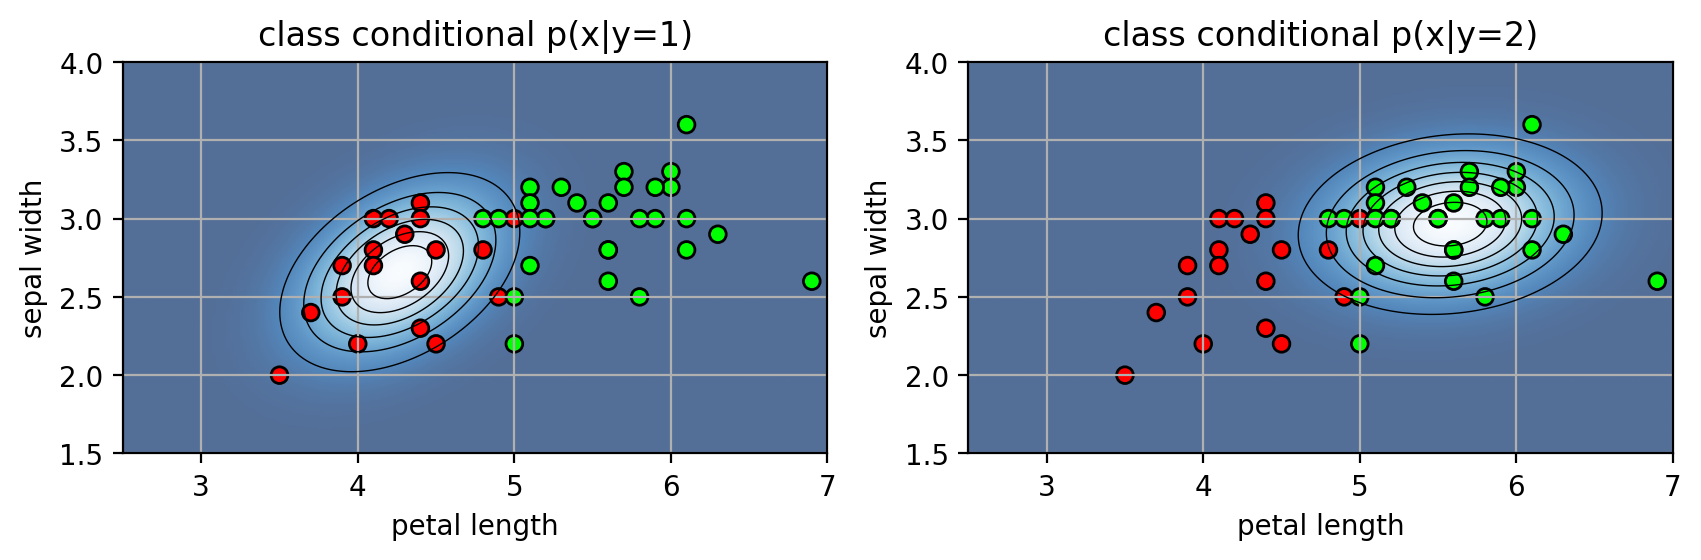

In [85]:
ccd2

- Posterior probability for the Gaussian classifier
  - the boundary better separates the data

In [86]:
p2fig = plt.figure(figsize=(9,8))
plot_posterior(gb, axbox, mycmap, showlabels=True)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plot_ellipse(plt.gca(), (gb.mu[0], gb.Sigma[0]), color='r')
plot_ellipse(plt.gca(), (gb.mu[1], gb.Sigma[1]), color='g')
plt.title('posterior p(y=2|x) with training data');
plt.close()

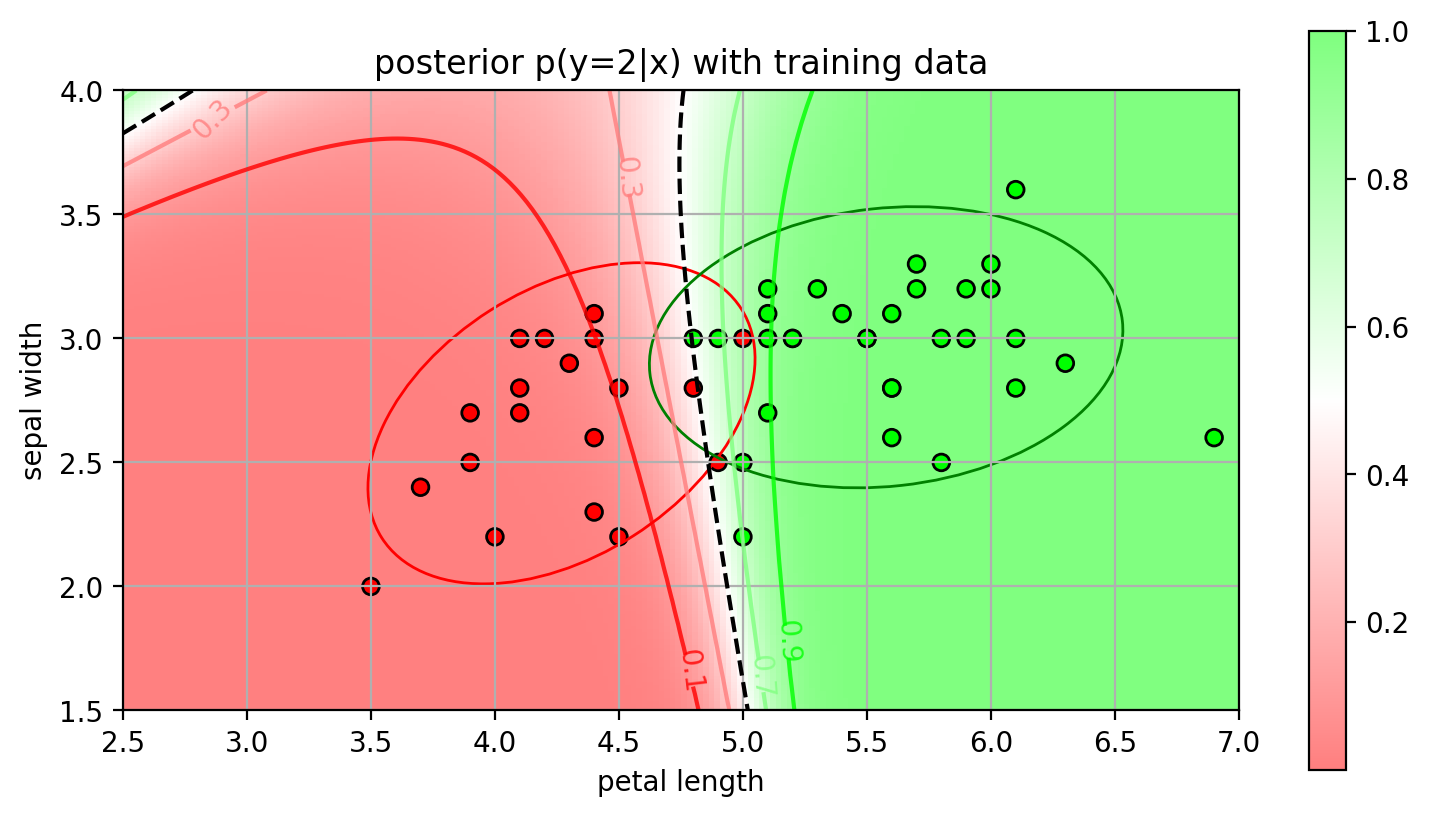

In [87]:
p2fig

- test accuracy is better than NB Gaussian
  - m.v. Gaussian is a better choice for the CCD for this dataset.

In [88]:
# predict from the model
predY = gb.predict(testX)+1   # map from 0..1 to 1..2
print("pred: ", predY)
print("true: ", testY)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("accuracy=", acc)

pred:  [2 2 1 2 1 2 1 1 1 1 2 2 2 2 2 1 2 2 1 2 1 1 1 1 1 1 1 1 2 1 2 1 2 2 1 1 1
 1 1 1 1 1 2 2 2 1 1 2 1 1]
true:  [2 2 1 2 1 2 1 1 1 1 1 2 2 2 2 1 2 2 1 1 1 1 2 1 1 1 1 1 2 1 2 1 2 2 1 1 2
 1 1 1 1 1 1 2 2 1 1 2 1 1]
accuracy= 0.9


# Example: Naive Bayes Spam Classifier
- Goal: given an input email, predict whether it is spam or not
  - input: text string
> A home based business opportunity is knocking at your door.
> Don't be rude and let this chance go by.
> You can earn a great income and find your financial life transformed.
> Learn more Here.
> To Your Success.
> Work From Home Finder Experts
  - output: spam, not spam (or ham)


# Text Document Representation
- Text document is a string!
  - we need to pick a suitable representation.
- **Bag-of-Words (BoW) model**
  - Let ${\cal V}=\{w_1, w_2, \cdots w_V\}$ be a list of $V$ words (called a **vocabulary**).
  - represent a text document as a vector $\mathbf{x}\in{\mathbb R}^V$.
    - each entry $x_j$ represents the number of times word $w_j$ appears in the document.
- **Example:**
  - Document: "This is a test document"
  - Vocabulary: ${\cal V} = \{\textrm{"this"}, \textrm{"test"}, \textrm{"spam"}, \textrm{"foo"}\}$
  - Vector representation: $\mathbf{x}=[1, 1, 0, 0]$

- **NOTE:**
  - the order of the words is not used!
  - rearranging words leads to the same representation!
- Example: 
  - "this is spam"  $\rightarrow \mathbf{x}=[1, 0, 1, 0]$
  - "is this spam" $\rightarrow \mathbf{x}=[1, 0, 1, 0]$
- This is why it is called "bag-of-words"
![](imgs/tom-mitchell-bow.jpg)
    

# Steps to make BoW
1. Build a vocabulary ${\cal V}$.
  - remove _stopwords_
    - the most common words that provide little information
    - examples: "the", "a", "on"
  - convert to all lower case
2. Calculate the vector for each document
  - count the occurence of each word in the vocabulary

In [89]:
# Load text data from directories
#   each sub-directory contains text files for 1 class
textdata = datasets.load_files("email", encoding="utf8", decode_error="replace")

# target names
print("class names = ", textdata.target_names)
print("classes = ", unique(textdata.target))
print("num samples = ", len(textdata.target))

class names =  ['ham', 'spam']
classes =  [0 1]
num samples =  50


In [90]:
# look at first sample
print("Sample 1 is Class " + str(textdata.target[0]) + \
  "(" + textdata.target_names[textdata.target[0]] + ")")
print("---")
print(textdata.data[0])

Sample 1 is Class 1(spam)
---
Get Up to 75% OFF at Online WatchesStore

Discount Watches for All Famous Brands

* Watches: aRolexBvlgari, Dior, Hermes, Oris, Cartier, AP and more brands
* Louis Vuitton Bags & Wallets
* Gucci Bags
* Tiffany & Co Jewerly

Enjoy a full 1 year WARRANTY
Shipment via reputable courier: FEDEX, UPS, DHL and EMS Speedpost
You will 100% recieve your order


In [91]:
# randomly split data into 50% train and 50% test set
traintext, testtext, trainY, testY = \
  model_selection.train_test_split(textdata.data, textdata.target, 
  train_size=0.5, test_size=0.5, random_state=11)

print(len(traintext))
print(len(testtext))

25
25


In [92]:
# setup the document vectorizer to make BoW
# - use english stop words
# - max_features: only use the most frequent words in the dataset
#                 (remove this to use all words in documents)
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=100)

# create the vocabulary
# NOTE: we only use the training data!
cntvect.fit(traintext)

# calculate the vectors for the training data
trainX = cntvect.transform(traintext)

# calculate vectors for the test data
testX  = cntvect.transform(testtext)

# print the vocabulary
# - (key,value) pairs correspond to (word,vector index)
print(cntvect.vocabulary_)

{'day': np.int64(31), 'mr': np.int64(63), 'john': np.int64(52), 'frank': np.int64(41), 'united': np.int64(92), 'nations': np.int64(65), 'representative': np.int64(78), 'states': np.int64(88), 'payment': np.int64(70), 'bank': np.int64(16), 'inheritance': np.int64(50), 'provide': np.int64(74), 'info': np.int64(47), 'names': np.int64(64), 'contact': np.int64(26), 'phone': np.int64(71), 'number': np.int64(68), 'address': np.int64(12), 'information': np.int64(49), 'required': np.int64(80), 'funds': np.int64(44), 'forward': np.int64(40), 'compensation': np.int64(25), 'david': np.int64(30), 'email': np.int64(34), 'send': np.int64(85), 'country': np.int64(28), 'nigeria': np.int64(67), 'today': np.int64(91), 'going': np.int64(45), 'codeine': np.int64(23), '15mg': np.int64(4), '30': np.int64(7), '70': np.int64(10), '30mg': np.int64(8), 'pills': np.int64(72), '60': np.int64(9), 'brand': np.int64(18), 'watson': np.int64(93), 'mg': np.int64(60), '120': np.int64(3), '10': np.int64(2), 'days': np.int

In [93]:
# define a function for prettier output...
def showVocab(vocab, counts=None):
    "print out the vocabulary. if counts specified, then only print the words w/ non-zero entries"
    allwords = list(vocab.keys())
    allwords.sort()  # sort vocabulary by index
    wordlist = []
    for word in allwords:
        ind = vocab[word]
        if (counts is None):
            mystr = "{:3d}. {}".format(ind, word)
        elif (counts[0,ind]>0):
            mystr = "{:3d}. ({:0.4f}) {}".format(ind, counts[0,ind], word)
        else:
            continue  # skip it
        wordlist.append(mystr)

    # print 2 columns
    it = iter(wordlist)
    for i in it:
        print('{:<30}{}'.format(i, next(it)))

In [94]:
# show the vocabulary with prettier outtput
showVocab(cntvect.vocabulary_)

  0. 00                         1. 000
  2. 10                         3. 120
  4. 15mg                       5. 20
  6. 2010                       7. 30
  8. 30mg                       9. 60
 10. 70                        11. account
 12. address                   13. adobe
 14. agaliofu                  15. andrew
 16. bank                      17. benoit
 18. brand                     19. chief
 20. choice                    21. close
 22. code                      23. codeine
 24. commented                 25. compensation
 26. contact                   27. cost
 28. country                   29. current
 30. david                     31. day
 32. days                      33. details
 34. email                     35. enabled
 36. extended                  37. federal
 38. financial                 39. following
 40. forward                   41. frank
 42. freeviagra                43. fund
 44. funds                     45. going
 46. gpu                       47. info
 48. info

In [95]:
# show a document vector
# sparse representation: only the non-zero entries are printed
print(trainX[0])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 22 stored elements and shape (1, 100)>
  Coords	Values
  (0, 12)	1
  (0, 16)	1
  (0, 26)	2
  (0, 31)	2
  (0, 40)	1
  (0, 41)	2
  (0, 44)	1
  (0, 47)	1
  (0, 49)	1
  (0, 50)	1
  (0, 52)	2
  (0, 63)	2
  (0, 64)	1
  (0, 65)	1
  (0, 68)	1
  (0, 70)	5
  (0, 71)	1
  (0, 74)	1
  (0, 78)	1
  (0, 80)	1
  (0, 88)	1
  (0, 92)	2


- because most of the entries are zero, the document vector is stored in "sparse" matrix format to save memory

In [96]:
type(trainX[0])

scipy.sparse._csr.csr_matrix

In [97]:
# convert to numpy array
trainX[0].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,
        0, 0, 1, 0, 5, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]])

In [98]:
# show the actual words
showVocab(cntvect.vocabulary_, trainX[0])
print("---")
print(traintext[0])

 12. (1.0000) address          16. (1.0000) bank
 26. (2.0000) contact          31. (2.0000) day
 40. (1.0000) forward          41. (2.0000) frank
 44. (1.0000) funds            47. (1.0000) info
 49. (1.0000) information      50. (1.0000) inheritance
 52. (2.0000) john             63. (2.0000) mr
 64. (1.0000) names            65. (1.0000) nations
 68. (1.0000) number           70. (5.0000) payment
 71. (1.0000) phone            74. (1.0000) provide
 78. (1.0000) representative   80. (1.0000) required
 88. (1.0000) states           92. (2.0000) united
---
Attn:Good Day,

Compliment of the day to you, my name is Mr John Frank Harmon a UNITED
NATIONS Representative here in UNITED STATES this year 2014 last
payment quarter for all outstanding payment from World Bank on overdue
contracts,inheritance and all other payment has commenced,you are to
provide the below info asap so that the payment processing can start
off.

Your full names
Contact phone number
Contact Address

The above inform

- For CountVectorizer, `fit` and `transform` are also combined into one function `fit_transform`.
  - build the vocabulary from training data, and return the training document vectors.

In [99]:
# setup the document vectorizer to make BoW
# - use english stop words
# - only use the most frequent 100 words in the dataset
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=100)

# create the vocabulary AND compute the training vectors
trainX = cntvect.fit_transform(traintext)

# calculate vectors for the test data
testX  = cntvect.transform(testtext)

# Naive Bayes model for Boolean vectors
- Model each word independently
  - absence/presence of a word $w_j$ in document
  - Bernoulli distribution
    - present: $p(x_j=1|y) = \pi_j$
    - absent: $p(x_j=0|y) = 1-\pi_j$
  - MLE parameters: $\pi_j=N_j/N$, 
    - $N_j$ is the number of documents in class $y$ that contain word $j$.
    - $N$ is the number of documents in class $y$.

- Class-conditional distribution
   $$p(x_1,\cdots,x_V|y=\textrm{spam}) = \prod_{j=1}^V p(x_j|y=\textrm{spam})$$
   $$\log p(x_1,\cdots,x_V|y=\textrm{spam}) = \sum_{j=1}^V \log p(x_j|y=\textrm{spam})$$
- for a document, the log-probabilities of the words being in a spam message adds.
  - accumulate evidence over all words in the document.
  - more words that are associated with spam --> more likely the document is spam

In [100]:
# fit the NB Bernoulli model.
# the model automatically converts count vector into binary vector
bmodel = naive_bayes.BernoulliNB(alpha=0.0)
bmodel.fit(trainX, trainY)

/Users/hanzhuo/miniconda3/envs/cityu_cs_courses/lib/python3.12/site-packages/sklearn/naive_bayes.py:1209: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


,alpha,0.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


In [101]:
# a function for plotting the word probabilities
def plotWordProb_OLD(model):
    xr = arange(0,len(cntvect.vocabulary_))
    plt.figure(figsize=(8,3))
    plt.bar(xr, exp(model.feature_log_prob_[0,:]), width=0.4, label=textdata.target_names[0])
    plt.bar(xr+0.5, exp(model.feature_log_prob_[1,:]), width=0.4, color='r', label=textdata.target_names[1])
    plt.legend()
    plt.xlabel('word index'); plt.ylabel('probability $p(x_j=1|y)$');
    plt.xlim(min(xr), max(xr)+1)

In [102]:
# a function for plotting the word probabilities
def plotWordProb(model):
    xr = arange(0,len(cntvect.vocabulary_))
    plt.figure(figsize=(8,3))
    plt.bar(xr, exp(model.feature_log_prob_[0,:]), width=0.8, label=textdata.target_names[0], alpha=0.5)
    plt.bar(xr, exp(model.feature_log_prob_[1,:]), width=0.8, color='r', label=textdata.target_names[1], alpha=0.5)
    plt.legend()
    plt.xlabel('word index'); plt.ylabel('probability $p(x_j=1|y)$');
    plt.xlim(min(xr), max(xr)+1)

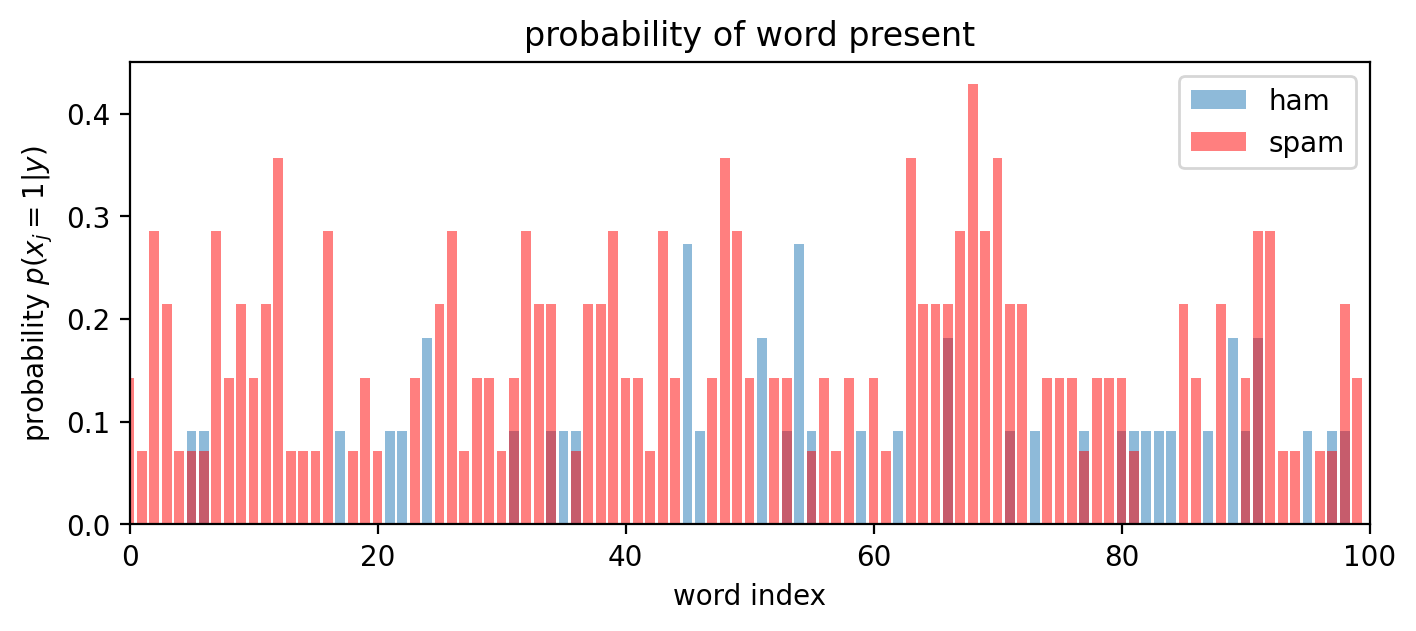

In [103]:
# make plot
plotWordProb(bmodel)
plt.title('probability of word present');

In [104]:
# prediction
predY = bmodel.predict(testX)
print("predictions: ", predY)
print("actual:      ", testY)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print(acc)

predictions:  [0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0]
actual:       [0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1]
0.64


In [105]:
# show examples of misclassified
inds = where(predY != testY)
print(inds)
for i in inds[0]:
    print("---- true={}, pred={}".format(testY[i], predY[i]))
    print(testtext[i])

(array([ 4,  7, 12, 17, 19, 21, 22, 23, 24]),)
---- true=0, pred=1
LinkedIn

Julius O requested to add you as a connection on LinkedIn:

Hi Peter.

Looking forward to the book!

 
Accept 	View invitation from Julius O

---- true=0, pred=1
Hi Peter,
 
The hotels are the ones that rent out the tent. They are all lined up on the hotel grounds : )) So much for being one with nature, more like being one with a couple dozen tour groups and nature.
I have about 100M of pictures from that trip. I can go through them and get you jpgs of my favorite scenic pictures.
 
Where are you and Jocelyn now? New York? Will you come to Tokyo for Chinese New Year? Perhaps to see the two of you then. I will go to Thailand for winter holiday to see my mom : )
 
Take care,
D

---- true=1, pred=0
Get Up to 75% OFF at Online WatchesStore

Discount Watches for All Famous Brands

* Watches: aRolexBvlgari, Dior, Hermes, Oris, Cartier, AP and more brands
* Louis Vuitton Bags & Wallets
* Gucci Bags
* Tiffany & Co Jew

# Smoothing
- Some words are not present in any documents for a given class.
  - $N_j=0$, and thus $\pi_j = 0$.
    - i.e., the document in the class **definitely** will not contain the word.
    - can be a problem since we simply may not have seem an example with that word.
- Smoothed MLE
  - add a smoothing parameter $\alpha$ that adds a "virtual" count
  - parameter: $\pi_j= (N_j+\alpha)/(N+2\alpha)$, 
  - this is called _Laplace smoothing_
- In general, _regularizing_ or _smoothing_ of the estimate helps to prevent _overfitting_ of the parameters.

In [106]:
# fit the NB Bernoulli model w/ smoothing (0.1)
bmodels = naive_bayes.BernoulliNB(alpha=0.1)
bmodels.fit(trainX, trainY)

,alpha,0.1
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


In [107]:
# prediction
predY = bmodels.predict(testX)
print("predictions: ", predY)
print("actual:      ", testY)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print(acc)
# a little better!

predictions:  [0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1]
actual:       [0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1]
0.72


- word probabilites

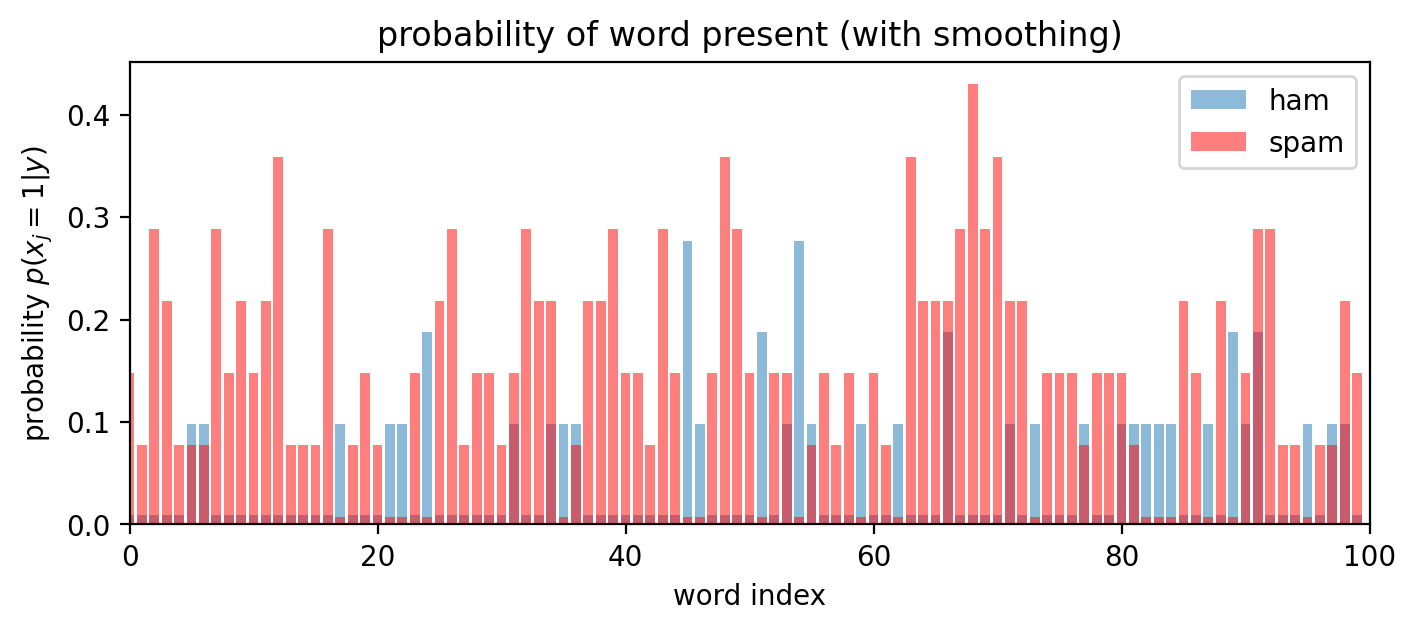

In [108]:
# make plot
plotWordProb(bmodels)
plt.title('probability of word present (with smoothing)');
# note the small probabilities are all slightly above 0.

- top-10 frequent words for spam class

In [109]:
# get the word names
fnames = asarray(cntvect.get_feature_names_out())
# feature_log_prob_ contains the scores for each word
# sort the coefficients in ascending order, and take the 10 largest.
tmp = argsort(bmodel.feature_log_prob_[1])[-10:]

for i in tmp:
    print("{:3d}. {:15s} ({:.5f})".format(i, fnames[i], bmodel.feature_log_prob_[1][i]))

 16. bank            (-1.25276)
 67. nigeria         (-1.25276)
 26. contact         (-1.25276)
 69. office          (-1.25276)
 32. days            (-1.25276)
 48. inform          (-1.02962)
 70. payment         (-1.02962)
 63. mr              (-1.02962)
 12. address         (-1.02962)
 68. number          (-0.84730)


# Most informative words
- The most informative words are those with high probability of being in one class, and low probability of being in other classes.
  - e.g., For class 1, find large values of $\log p(w_j|y=1) - \log p(w_j|y=0)$

In [110]:
# get the word names
fnames = asarray(cntvect.get_feature_names_out())

# feature_log_prob_ contains the scores for each word 
# (higher means more informative)
# calculate the log-probability difference
score = bmodel.feature_log_prob_[1] - bmodel.feature_log_prob_[0]

# sort the coefficients in ascending order, and take the 10 largest.
tmp = argsort(score)[-10:]

for i in tmp:
    print("{:3d}. {:15s} ({:.5f})".format(i, fnames[i], score[i]))

 39. following       (inf)
 38. financial       (inf)
 37. federal         (inf)
 33. details         (inf)
 32. days            (inf)
 30. david           (inf)
 29. current         (inf)
 28. country         (inf)
 26. contact         (inf)
 99. york            (inf)


# Naive Bayes for Count Vectors
- Now we consider using the number of times each word appears in the document $D$.
- Two ways to create a document vector $x$ based on the word counts.

- **Term-Frequency (TF)**
  - handles documents with different lengths (number of words).
  - normalize the count to a frequency, by dividing by the number of words in the document.
    - $x_j = \frac{w_j}{|D|}$
      - $w_j$ is the number of times word $j$ appears in the document
      - $|D|$ is the number of words in the document.

- **Term-Frequency Inverse Document Frequency (TF-IDF)**
  - some words are common among many documents
    - common words are less informative because they appear in both classes.
  - **inverse document frequency (IDF)** - measure rarity of each word
    - $IDF(j) = \log \frac{N}{N_j}$
      - $N$ is the number of documents.
      - $N_j$ is the number of documents with word $j$.
    - IDF is:
      - 0 when a word is common to all documents
      - large value when the word appears in few documents
  - **TF-IDF vector:** downscale words that are common in many documents
    - multiply TF and IDF terms
    - $x_j = \frac{w_j}{|D|} \log \frac{N}{N_j}$

In [111]:
# TF-IDF representation
# (For TF, pass use_idf=False)
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
# 'l1' - entries sum to 1

# setup the TF-IDF representation, and transform the training set
trainXtf = tf_trans.fit_transform(trainX)

# transform the test set 
testXtf = tf_trans.transform(testX)

print(trainXtf[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 22 stored elements and shape (1, 100)>
  Coords	Values
  (0, 12)	0.027584840028916233
  (0, 16)	0.02962402236194771
  (0, 26)	0.05924804472389542
  (0, 31)	0.06423955966673983
  (0, 40)	0.03533737083022896
  (0, 41)	0.07067474166045792
  (0, 44)	0.03533737083022896
  (0, 47)	0.03533737083022896
  (0, 49)	0.02962402236194771
  (0, 50)	0.03533737083022896
  (0, 52)	0.07067474166045792
  (0, 63)	0.05516968005783247
  (0, 64)	0.032119779833369916
  (0, 65)	0.032119779833369916
  (0, 68)	0.0258607359325269
  (0, 70)	0.13792420014458118
  (0, 71)	0.02962402236194771
  (0, 74)	0.03533737083022896
  (0, 78)	0.03533737083022896
  (0, 80)	0.032119779833369916
  (0, 88)	0.032119779833369916
  (0, 92)	0.05924804472389542


In [112]:
showVocab(cntvect.vocabulary_, trainXtf[0])

 12. (0.0276) address          16. (0.0296) bank
 26. (0.0592) contact          31. (0.0642) day
 40. (0.0353) forward          41. (0.0707) frank
 44. (0.0353) funds            47. (0.0353) info
 49. (0.0296) information      50. (0.0353) inheritance
 52. (0.0707) john             63. (0.0552) mr
 64. (0.0321) names            65. (0.0321) nations
 68. (0.0259) number           70. (0.1379) payment
 71. (0.0296) phone            74. (0.0353) provide
 78. (0.0353) representative   80. (0.0321) required
 88. (0.0321) states           92. (0.0592) united


# Naive Bayes Multinomial
- TF or TF-IDF representation
  - Document word vector $\mathbf{x}$
    - $x_j$ is the frequency of word $j$ occuring in the document.
    - vector $\mathbf{x}$ sums to 1, i.e. $\sum_{j} x_j = 1$.
- Use a multinomial distribution as the class conditional
  - based on the frequency that a word appears in a document of a class.
  - $p(\mathbf{x}|y) = \frac{(\sum_j x_j)!}{\prod_j x_j!}\left(\prod_j \pi_{j,y}^{x_j}\right)$
    - $\pi_{j,y}$ = the probability that word $w_j$ occurs in class $y$.
    - $\sum_{j=1}^V \pi_{j,y} = 1$


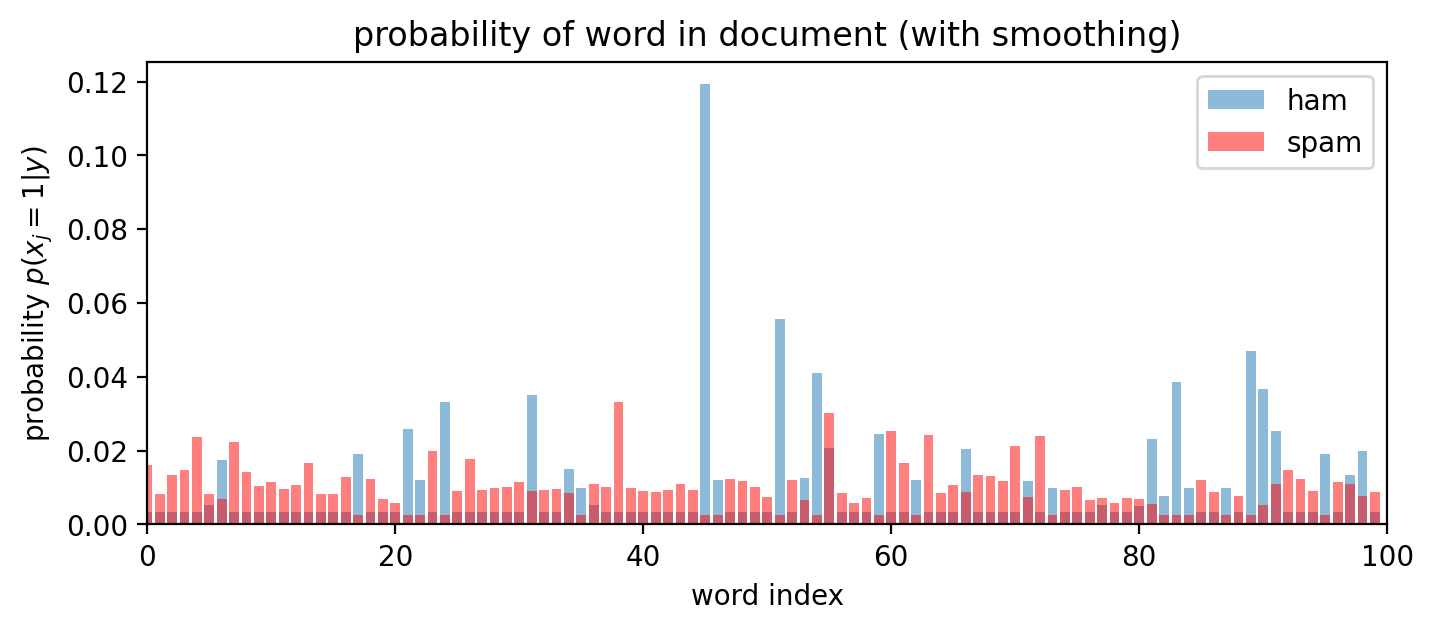

In [113]:
# fit a multinomial model (with smoothing)
mmodel_tf = naive_bayes.MultinomialNB(alpha=0.05)
mmodel_tf.fit(trainXtf, trainY)

# show the word probabilites
plotWordProb(mmodel_tf)
plt.title('probability of word in document (with smoothing)');

In [114]:
# prediction
predYtf = mmodel_tf.predict(testXtf)
print("prediction: ", predYtf)
print("actual:     ", testY)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYtf)
print(acc)

prediction:  [0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1]
actual:      [0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1]
0.68


In [115]:
# most frequent TF-IDF words for spam class
fnames = asarray(cntvect.get_feature_names_out())
tmp = argsort(mmodel_tf.feature_log_prob_[1])[-10:]
for i in tmp:
    print("{:3d}. {:15s} ({:.5f})".format(i, fnames[i], mmodel_tf.feature_log_prob_[1][i]))

 26. contact         (-4.03474)
 23. codeine         (-3.92301)
 70. payment         (-3.85287)
  7. 30              (-3.80167)
  4. 15mg            (-3.74496)
 72. pills           (-3.72604)
 63. mr              (-3.71758)
 60. mg              (-3.68161)
 55. let             (-3.49983)
 38. financial       (-3.40804)


In [116]:
# most informative TF-IDF for spam class
fnames = asarray(cntvect.get_feature_names_out())
score = mmodel_tf.feature_log_prob_[1] - mmodel_tf.feature_log_prob_[0]
tmp = argsort(score)[-10:]
for i in tmp:
    print("{:3d}. {:15s} ({:.5f})".format(i, fnames[i], score[i]))

 13. adobe           (1.61513)
 26. contact         (1.66904)
 23. codeine         (1.78077)
 70. payment         (1.85091)
  7. 30              (1.90211)
  4. 15mg            (1.95882)
 72. pills           (1.97775)
 63. mr              (1.98621)
 60. mg              (2.02217)
 38. financial       (2.29575)


# Summary
- **Generative classification model**
  - estimate probability distributions of features generated from each class.
  - given feature observation predict class with largest posterior probability.
- **Advantages:**
  - works with small amount of data.
  - works with multiple classes.
- **Disadvantages:**
  - accuracy depends on selecting an appropriate probability distribution.
    - if the probability distribution doesn't model the data well, then accuracy might be bad.

- **Other text preprocessing**
  - _Stemming_
    - convert related words into a common root word
    - example: testing, tests &rarr; "test"
    - see NLTK toolbox (http://www.nltk.org)
  - _Lemmatisation_
    - similar to stemming
    - groups inflections of word together (gone, going, went &rarr; go)
    - see NLTK
  - Removing numbers and punctuation.

- **Other word models**
  - _N-grams_
    - similar to BoW except look at pairs of consecutive words (or N consecutive words in general)
  - _word vectors_ 
    - each word is a real vector, where direction indicates the "concept"
    - words about similar things point in the same direction
    - adding and subtracting word vectors yield new word vectors